In [11]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import scipy
Image.MAX_IMAGE_PIXELS = None

In [12]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# Veri seti klasörünün yolu (Data klasörünüzün yolu)
data_dir = Path('Train')
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images, train_size=0.8, shuffle=True, random_state=1)

In [14]:
# Requariments
# pip install numpy,pandas,seaborn,matlpot,path,tensorflow 
# pip install scikit-learn
# $conda install -c conda-forge tensorflow

# DATA AGUMENTATION


In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    vertical_flip=True,
    rescale=1./255,
    rotation_range=30,  # Örneğin, 0 ile 90 derece arasında rastgele döndürme
    zoom_range=[0.8, 1.2]  # Rastgele yakınlaştırma aralığı
) # %70 eğitim datası içinden ön eğitim kontrölü içinde %20 yani 140 adet ön test (daha önceden gördüğü veri üzerinden test yapmak için) veri ayırıyoruz


In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 18246 validated image filenames belonging to 4 classes.
Found 4561 validated image filenames belonging to 4 classes.
Found 5702 validated image filenames belonging to 4 classes.


# MODEL CREATE

In [18]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224,224,3), # resimde 3 girişli bir kanal (ağ) yapısı vardır standart ölçü
                    include_top=False,# katmanın başlangıç noktası (en üst kısmıdır) veri kalitesi ve eğitim açısından eklenmez bu yüzden False ise eklenmeyecek ise tanımlamak zorundayız
                    weights='imagenet', # Fine-Tuning (öncedene eğitilmiş bir modeli alıyoruz)
                    pooling='avg')

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Örneğin, 0.5 olasılıkla Dropout uygula

#x = tf.keras.layers.Dropout(0.3)(x)  # Örneğin, 0.5 olasılıkla Dropout uygula
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # 4 sınıf sayısıdır softmax (sigmoid ile arasındaki farka bakılacak)
model = tf.keras.Model(inputs, outputs)

In [19]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [20]:
from keras.optimizers import Adam
adam = Adam(learning_rate = 0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


#from keras.optimizers import Adam
#adam = Adam(learning_rate = 0.0005) # methods (lr=0.0005, batch_size=32, epochs=20)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True) # ayrıntı çubuğu için
history = model.fit(train_images,validation_data=val_images,epochs=300,batch_size =64,callbacks=[callbacks])

# Öğrenme Oranı Artırma - GRAFİK TAKİPİ

Eğer kayıp hızlı bir şekilde azalıyorsa, öğrenme oranını artırabilirsiniz.
Eğer kayıp çok yavaş veya hızlı dalgalanıyorsa, öğrenme oranını düşürebilirsiniz.

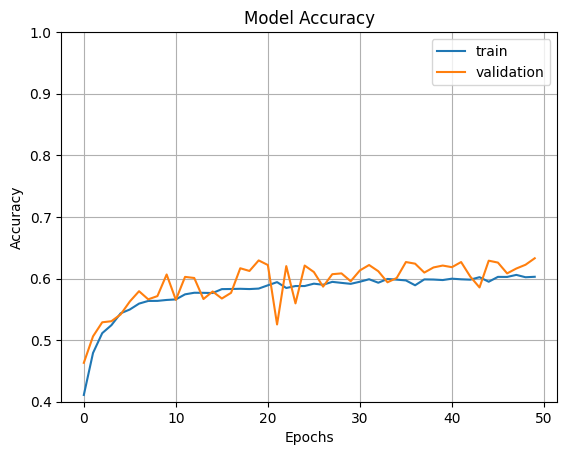

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("5 Aralık/Val_Accury_bacth64_epoch100.png",dpi=200)
plt.show()
     

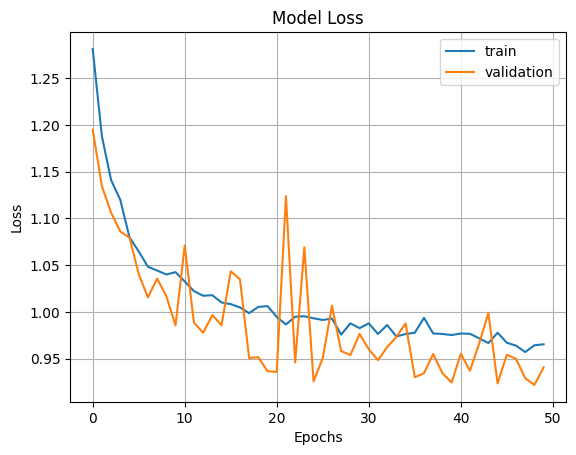

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("5 Aralık/Val_Loss_bacth64_epoch100.png",dpi=200)
plt.show()

In [16]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.9115923047065735, 0.6213608980178833]
Test Accuracy: 62.14%


In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

179/179 [==============================] - 24s 128ms/step


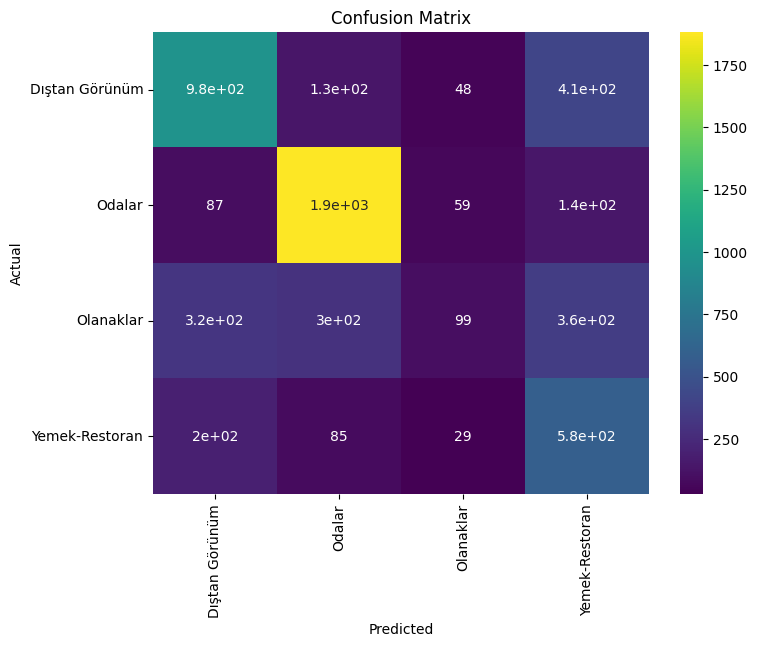

In [18]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices.keys(), rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices.keys(), rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("5 Aralık/Confusion Matrix_Softmax_Dropout_02_bacth64_epoch100.png",dpi=200)

179/179 [==============================] - 24s 135ms/step


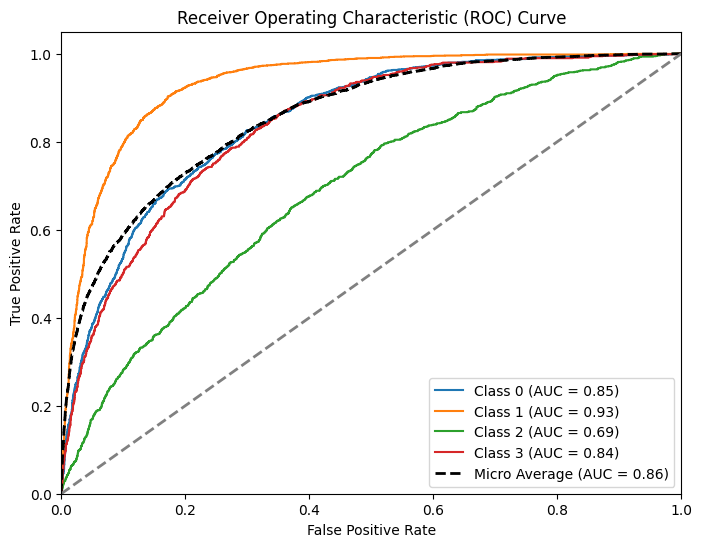

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# ROC eğrisini çıkarmak için One-vs-Rest sınıflandırıcı kullanın
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_images.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro average ROC curve ve ROC alanını hesaplayın
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC eğrisini çizin
plt.figure(figsize=(8, 6))

for i in range(len(test_images.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro Average (AUC = {roc_auc["micro"]:.2f})', linestyle='--', linewidth=2, color='black')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("5 Aralık/ROC_bacth64_epoch100.png",dpi=200)
plt.show()


179/179 [==============================] - 23s 128ms/step


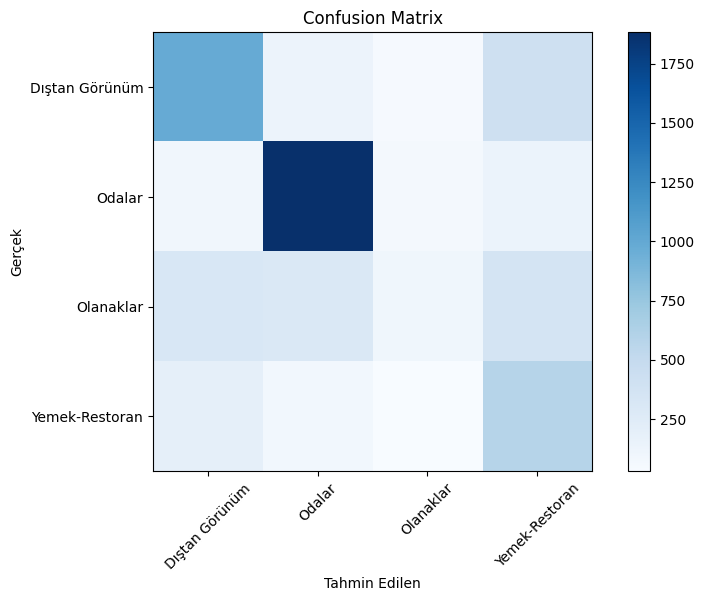

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# ROC eğrisini çıkarmak için One-vs-Rest sınıflandırıcı kullanın
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_images.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro average ROC curve ve ROC alanını hesaplayın
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC Curve ve Confusion Matrix'i aynı grafikte göster
plt.figure(figsize=(16, 6))


# Confusion Matrix
plt.subplot(1, 2, 1)

# Örnek confusion matrix
cm = confusion_matrix(test_images.labels, np.argmax(predictions, axis=1))

# Görselleştirme
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_images.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.savefig("5 Aralık/Confusion Matrix_bacth64_epoch100.png",dpi=200)

plt.show()


179/179 [==============================] - 23s 130ms/step


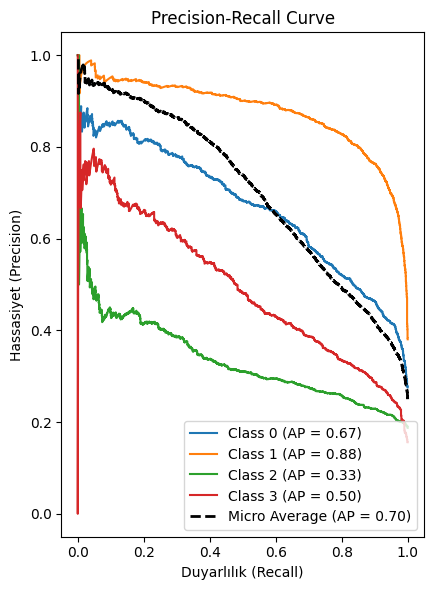

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Modelinizden tahminler yapın
predictions = model.predict(test_images)

# Etiketleri ikili forma çevirin (one-hot encoding)
test_labels_bin = label_binarize(test_images.labels, classes=[0, 1, 2, 3])

# Precision-Recall Curve'ü çıkarmak için One-vs-Rest sınıflandırıcı kullanın
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(test_images.class_indices)):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_bin[:, i], predictions[:, i])

# Micro average Precision-Recall curve ve Precision alanını hesaplayın
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels_bin.ravel(), predictions.ravel())
average_precision["micro"] = average_precision_score(test_labels_bin, predictions, average="micro")

# Precision-Recall Curve,  grafikte göster
plt.figure(figsize=(12, 6))

# Precision-Recall Curve
plt.subplot(1, 3, 1)

for i in range(len(test_images.class_indices)):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.plot(recall["micro"], precision["micro"], label=f'Micro Average (AP = {average_precision["micro"]:.2f})', linestyle='--', linewidth=2, color='black')

plt.xlabel('Duyarlılık (Recall)')
plt.ylabel('Hassasiyet (Precision)')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.savefig("5 Aralık/Precision-Recall Curve_bacth64_epoch100.png",dpi=200)

plt.tight_layout()
plt.show()


In [24]:
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

Dıştan Görünüm       0.62      0.62      0.62      1573
        Odalar       0.79      0.87      0.82      2170
     Olanaklar       0.42      0.09      0.15      1069
Yemek-Restoran       0.39      0.65      0.49       890

      accuracy                           0.62      5702
     macro avg       0.55      0.56      0.52      5702
  weighted avg       0.61      0.62      0.59      5702



In [25]:
data_his = pd.DataFrame(history.history)
train_images.class_indices.keys()
train_images.class_indices.values()
df=pd.DataFrame({'names':list(train_images.class_indices.keys()),
                 'index':list(train_images.class_indices.values())})
df.iloc[0]['names']


'Dıştan Görünüm'

In [26]:
import warnings
warnings.filterwarnings("ignore")
model.save('5 Aralık/ResNet_bacth64_epoch100_Softmax_Drop.h5')

# TKINTER VIEW

from tensorflow.keras.preprocessing import image
dir_path = 'test'

for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'/'+i,target_size=(650,650))
    plt.imshow(img)
    plt.show()
    
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis=0)
    images = np.vstack([X])
    predictions = np.argmax(model.predict(images), axis=1)
    print(df.iloc[predictions]['names'])